In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [3]:
df = pd.read_csv('IT_Salary_Survey_EU _2020.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 24/11/2020 11:14:15 to 19/01/2021 12:01:11
Data columns (total 22 columns):
 #   Column                                                                                                                   Non-Null Count  Dtype  
---  ------                                                                                                                   --------------  -----  
 0   Age                                                                                                                      1226 non-null   float64
 1   Gender                                                                                                                   1243 non-null   object 
 2   City                                                                                                                     1253 non-null   object 
 3   Position                                                                                                      

## Data Preparation Stage

### Switching types to numeric and filling NA

In [4]:
# For Age the better choice for NA is median
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['Age'] = df['Age'].fillna(df['Age'].median())

In [5]:
# For Total years of experience the better choice for NA is median
df['Total years of experience'] = pd.to_numeric(df['Total years of experience'], errors='coerce')
df['Total years of experience'] = df['Total years of experience'].fillna(df['Total years of experience'].median())
df = df[df['Total years of experience'] < 70] # One outlier was found which has Total years of experience more than 100 which, obviously, is unrealistic

In [6]:
# For Years of experience in Germany the better choice for NA is median
df['Years of experience in Germany'] = pd.to_numeric(df['Years of experience in Germany'], errors='coerce')
df['Years of experience in Germany'] = df['Years of experience in Germany'].fillna(df['Years of experience in Germany'].median())

In [7]:
# Yearly bonus is filled only if it is given to a worker; thus, all NA should be replaced with 0
df['Yearly bonus + stocks in EUR'] = pd.to_numeric(df['Yearly bonus + stocks in EUR'], errors='coerce')
df['Yearly bonus + stocks in EUR'] = df['Yearly bonus + stocks in EUR'].fillna(0)

In [8]:
# The most complex case: Annual bonus+stocks one year ago can be NA either if a person worked in another country or if he/she has not obtained any bonuses
# Currently NA is replaced with median, but probably it would be better to fill NA with either 0 or median based on the fact of working in Germany in previous year
df['Annual bonus+stocks one year ago. Only answer if staying in same country'] = pd.to_numeric(df['Annual bonus+stocks one year ago. Only answer if staying in same country'], errors='coerce')
df['Annual bonus+stocks one year ago. Only answer if staying in same country'] = df['Annual bonus+stocks one year ago. Only answer if staying in same country'].fillna(df['Annual bonus+stocks one year ago. Only answer if staying in same country'].median())

In [9]:
# NA means that the person worked somewhere else, so NA is replaced with median
df['Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country'] = df['Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country'].fillna(df['Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country'].median())

In [10]:
# For Number of vacation days the better choice for NA is median
df['Number of vacation days'] = pd.to_numeric(df['Number of vacation days'], errors='coerce')
df['Number of vacation days'] = df['Number of vacation days'].fillna(df['Number of vacation days'].median())

In [11]:
# NA here should be replaced with 0, since NA means that there was no monetary support, which is equal to 0 euro
df['Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR'] = pd.to_numeric(df['Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR'], errors='coerce')
df['Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR'] = df['Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR'].fillna(0)

In [12]:
# NA means that a person has not been forced to have a shorter working week, so 0 is appropriate for NA
df['Have you been forced to have a shorter working week (Kurzarbeit)? If yes, how many hours per week'] = df['Have you been forced to have a shorter working week (Kurzarbeit)? If yes, how many hours per week'].fillna(0)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1252 entries, 24/11/2020 11:14:15 to 19/01/2021 12:01:11
Data columns (total 22 columns):
 #   Column                                                                                                                   Non-Null Count  Dtype  
---  ------                                                                                                                   --------------  -----  
 0   Age                                                                                                                      1252 non-null   float64
 1   Gender                                                                                                                   1242 non-null   object 
 2   City                                                                                                                     1252 non-null   object 
 3   Position                                                                                                      

### Generating dummy variables for existing categorical variables besides City, Position, Employment status and technologies.

Position has lots of different values while some of them cover each other such as Software Engineer and Backend/Fronted Developer; therefore, it was decided not to consider it as a potential predictor. Columns with technology are nearly the same: they have lots of different values, intersecting with each other, and would generate dozes of new columns, where each column would have quite small amount of non-zero data, so it was also decided to omit them. Nearly the same is for 'City'. Employment status has more than 96% values equal only to 'Full-time employee', so this variable is not very representative at this dataset, as well.

If count for a given category is less than 4, this category becomes 'other'.

In [14]:
df.loc[df.groupby('Seniority level')['Seniority level'].transform('count').lt(4), 'Seniority level'] = 'other'
df.loc[df.groupby('Сontract duration')['Сontract duration'].transform('count').lt(4), 'Сontract duration'] = 'other'
df.loc[df.groupby('Main language at work')['Main language at work'].transform('count').lt(4), 'Main language at work'] = 'other'
df.loc[df.groupby('Company type')['Company type'].transform('count').lt(4), 'Company type'] = 'other'
df.loc[df.groupby('Have you lost your job due to the coronavirus outbreak?')['Have you lost your job due to the coronavirus outbreak?'].transform('count').lt(4), 'Have you lost your job due to the coronavirus outbreak?'] = 'other'

In [15]:
df_with_dummies = pd.get_dummies(df, columns=['Gender'])
df_with_dummies = pd.get_dummies(df_with_dummies, columns=['Seniority level'])
df_with_dummies = pd.get_dummies(df_with_dummies, columns=['Сontract duration'])
df_with_dummies = pd.get_dummies(df_with_dummies, columns=['Main language at work'])
df_with_dummies = pd.get_dummies(df_with_dummies, columns=['Company size'])
df_with_dummies = pd.get_dummies(df_with_dummies, columns=['Company type'])
df_with_dummies = pd.get_dummies(df_with_dummies, columns=['Have you lost your job due to the coronavirus outbreak?'])

### Choosing dependent variable and predictors

In [16]:
df_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1252 entries, 24/11/2020 11:14:15 to 19/01/2021 12:01:11
Data columns (total 44 columns):
 #   Column                                                                                                                   Non-Null Count  Dtype  
---  ------                                                                                                                   --------------  -----  
 0   Age                                                                                                                      1252 non-null   float64
 1   City                                                                                                                     1252 non-null   object 
 2   Position                                                                                                                 1246 non-null   object 
 3   Total years of experience                                                                                     

#### Dependent variable is 'Yearly brutto salary (without bonus and stocks) in EUR'

Note. Maybe it would be even better to consider a sum of 'Yearly brutto salary (without bonus and stocks) in EUR' and 'Yearly bonus + stocks in EUR', since their sum really represents how much money the worker obtains, but in the task it is said that the dependent variable is specifically salary, so 'Yearly brutto salary (without bonus and stocks) in EUR' is chosen

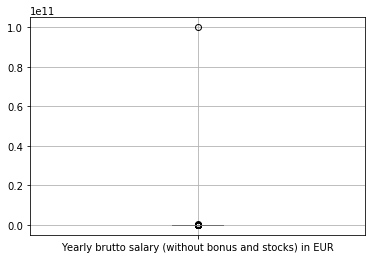

In [17]:
df_with_dummies.boxplot(column='Yearly brutto salary (without bonus and stocks) in EUR')

It is seen that there is an extreme value which enormously deviates from all the other values. It is decided to remove this value to neutralize its influence on the linear regression

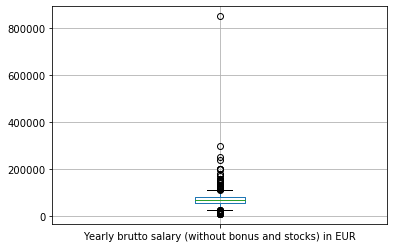

In [18]:
df_with_dummies = df_with_dummies[df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR'] < 100000000]
df_with_dummies.boxplot(column='Yearly brutto salary (without bonus and stocks) in EUR')

In [19]:
df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR'].describe()

count      1250.000000
mean      71656.281704
std       32831.373788
min       10001.000000
25%       58200.000000
50%       70000.000000
75%       80000.000000
max      850000.000000
Name: Yearly brutto salary (without bonus and stocks) in EUR, dtype: float64

##### Hypothesis:

H1: The distribution of the variable 'Yearly brutto salary (without bonus and stocks) in EUR' is different from the normal distribution

H0: The distribution of the variable 'Yearly brutto salary (without bonus and stocks) in EUR' is not different from the normal distribution

p-value = 0.05

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

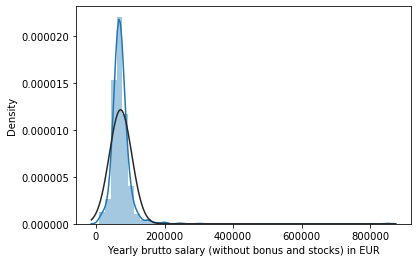

In [20]:
sns.distplot(df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR'], fit=stats.norm)

In [21]:
stats.kstest(df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR'], 'norm', args=(df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR'].mean(), df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR'].std()))

KstestResult(statistic=0.17581263490895493, pvalue=2.8913884795922062e-34)

In [22]:
print('Skewness: {:.4f}'.format(df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR'].skew()))
print('Kurtosis: {:.4f}'.format(df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR'].kurt()))
print('Quartile Deviation: {:.4f}'.format((df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR'].quantile(0.75) - df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR'].quantile(0.25))/2))
print('Decile Ratio: {:.4f}'.format(df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR'].quantile(0.9)/df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR'].quantile(0.1)))

Skewness: 11.5492
Kurtosis: 256.0657
Quartile Deviation: 10900.0000
Decile Ratio: 1.9792


##### Conclusion:

The dependent variable 'Yearly brutto salary (without bonus and stocks) in EUR' deviates from the normal distribution (H1 is accepted at p-value = 0.05). It has a highly skewed leptokurtic distribution with positive skewness.

The mean value is 71654, the standard deviation is sufficiently high - 32818. The median is 70000, which is very close now to the mean after removing one extreme value. The quartile deviation is 10800, which characterizes a quite low spread of the central 50% of values relative to the median. The decile ratio is 1.98 which is not that high. With all that in mind, it is possible to say that the dispersion between 90 percentile and 10 percentile is sufficiently low, while the actual difference between the absolute mininum and absolute maximum values is quite high and is equal to 839000$

### Correlations among variables

Potential predictors can be those which have a greater correlation with the dependent variable than others

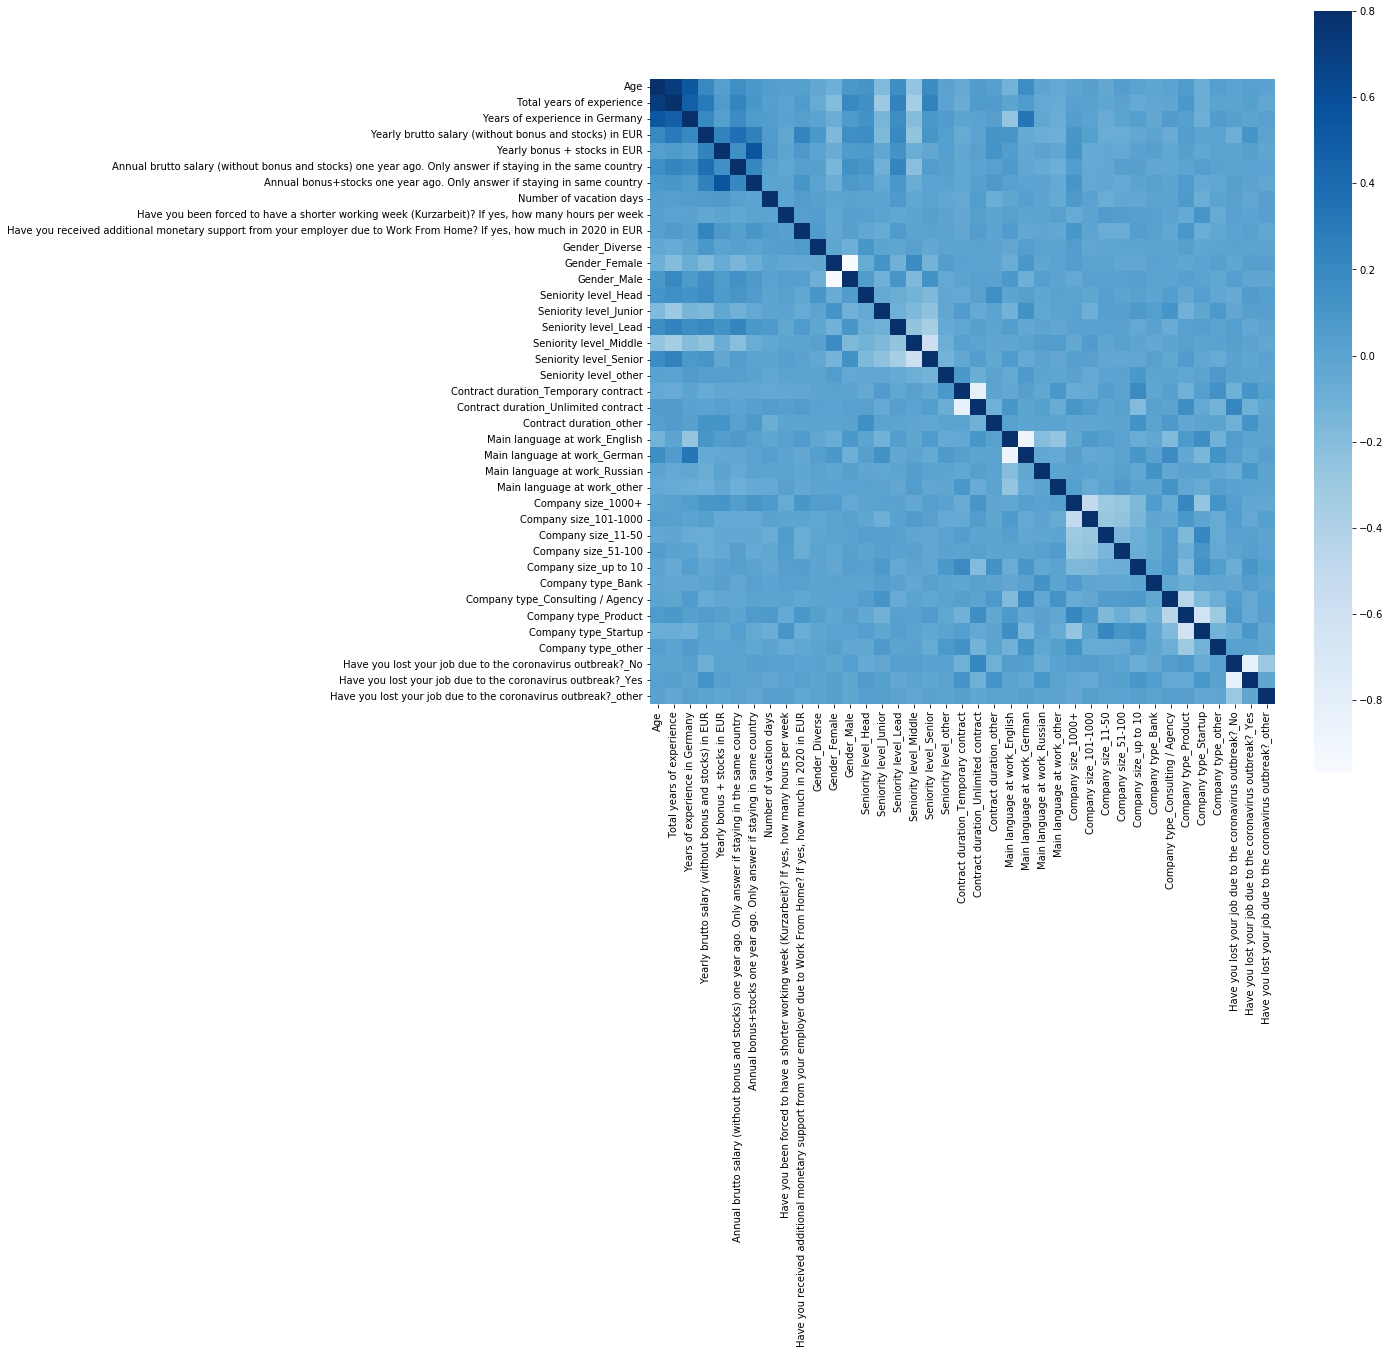

In [23]:
corr = df_with_dummies.corr()
plt.figure(figsize=(14, 14))
sns.heatmap(corr, vmax=.8, square=True, cmap='Blues')
plt.show()

It is seen that some variables have significant correlation with each other. Based on corr matrix we check correlations between 'Total years of experience', 'Age' and 'Years of experience in Germany' as well as between 'Annual bonus+stocks one year ago. Only answer if staying in same country' and 'Yearly bonus + stocks in EUR'

In [24]:
df_with_dummies['Total years of experience'].corr(df_with_dummies['Age'])

0.71448880568161

In [25]:
df_with_dummies['Years of experience in Germany'].corr(df_with_dummies['Age'])

0.5311533459140761

In [26]:
df_with_dummies['Annual bonus+stocks one year ago. Only answer if staying in same country'].corr(df_with_dummies['Yearly bonus + stocks in EUR'])

0.551209090383727

There is medium correlation between 'Total years of experience' and 'Age' as well as between 'Years of experience in Germany' and 'Age', which seems logical as years of experience highly depend on the age on a person. Moreover, there is a medium correlation between 'Annual bonus+stocks one year ago. Only answer if staying in same country' and 'Yearly bonus + stocks in EUR' showing that the bonuses in the last year depend on bonuses in the current year.
The correlation is generally not that high to exclude some of these variables from predictors (but the correlation = 0.71 is still on the border).

In [27]:
df_with_dummies.corrwith(df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR']).sort_values(ascending=False)

Yearly brutto salary (without bonus and stocks) in EUR                                                                     1.000000
Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country                   0.368158
Total years of experience                                                                                                  0.298248
Annual bonus+stocks one year ago. Only answer if staying in same country                                                   0.251069
Yearly bonus + stocks in EUR                                                                                               0.234127
Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR    0.230168
Years of experience in Germany                                                                                             0.204420
Seniority level_Lead                                                        

Variables which have not very weak correlation with the dependent variable, which can become predictors:

- Annual brutto salary (without bonus and stocks) one year ago.
- Annual bonus+stocks one year ago
- Yearly bonus + stocks in EUR
- Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR
- Years of experience in Germany
- Seniority level (cat.)
- Age
- Gender (cat.)
- Total years of experience
- Have you lost your job due to the coronavirus outbreak? (cat.)
- Company size (cat.)
- Main language at work (cat.)

To have a well-fitted linear model, there should be linear relationship between each dependent variable and the predictor. Linear relationship can be checked on scatter plots. Note that the task requires to have not less than 10 dependent variables, so hereafter if the variable even does not have a linear relationship, it is still considered as a predictor to overcome this border of 10 predictors. However, in the end it would be seen, either these non-linear predictors are statistically significant for the model or not, as well as do they really provide a significant influence on the model or not.

### Predictor: Annual brutto salary (without bonus and stocks) one year ago

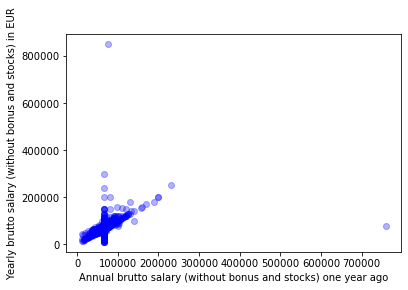

In [28]:
plt.scatter(df_with_dummies['Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country'], df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR'], c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('Annual brutto salary (without bonus and stocks) one year ago')
plt.ylabel('Yearly brutto salary (without bonus and stocks) in EUR')
plt.show()

There is a positive linear relationship. We can see 2 extreme outliers on the bottom right: one has low brutto salary in the previous year and huge in this year and another has totally opposite situation

### Predictor: Annual bonus+stocks one year ago

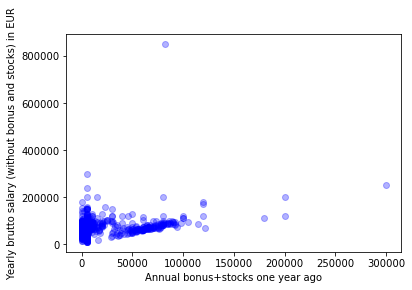

In [29]:
plt.scatter(df_with_dummies['Annual bonus+stocks one year ago. Only answer if staying in same country'], df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR'], c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('Annual bonus+stocks one year ago')
plt.ylabel('Yearly brutto salary (without bonus and stocks) in EUR')
plt.show()

There is also a positive linear relationship. However, it is seen that many workers do not obtain annual bonuses at all; that is why, for many of them the value of salary does not influence the amount of annual bonuses. But if a worker obtains annual bonuses, there appears a linear relationship between these 2 variables. However, there exists one outlier who has enourmous brutto salary but only above average bonuses

### Predictor: Yearly bonus + stocks in EUR

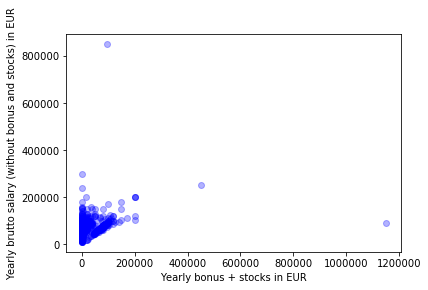

In [30]:
plt.scatter(df_with_dummies['Yearly bonus + stocks in EUR'], df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR'], c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('Yearly bonus + stocks in EUR')
plt.ylabel('Yearly brutto salary (without bonus and stocks) in EUR')
plt.show()

There is also a positive linear relationships but a bit less explicit than in the previous example. Again, there is a big portion of workers who obtain salary (which can be even high) and do not obtain any yearly bonuses at all.

### Predictor: Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR

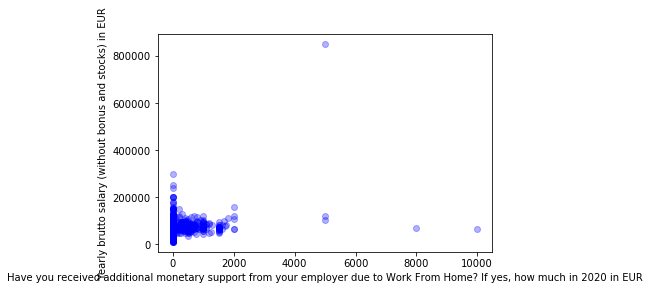

In [31]:
plt.scatter(df_with_dummies['Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR'], df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR'], c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR')
plt.ylabel('Yearly brutto salary (without bonus and stocks) in EUR')
plt.show()

Here, it is not really possible to say that there is specifically linear correlation, since the graph shows that starting from some amount of brutto salary you have a chance to get additional monetary support, but from the graph is not possible to say that if the brutto salary is higher, than the monetary support is higher as well. This monetary support is nearly the same for all the salaries

### Predictor: Years of experience in Germany

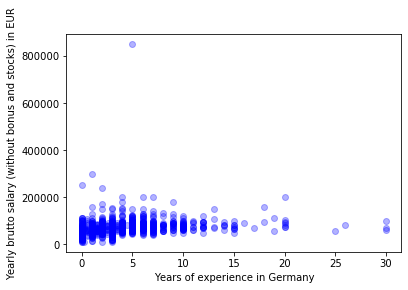

In [32]:
plt.scatter(df_with_dummies['Years of experience in Germany'], df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR'], c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('Years of experience in Germany')
plt.ylabel('Yearly brutto salary (without bonus and stocks) in EUR')
plt.show()

It is seen that that the more years of experience a worker has, generally the greater salary he/she obtains. But it is probably not linear relationship - I would try to guess that is more of logistic relationship since from some point of years of experience the increase in salary almost stops.

### Predictor: Seniority level (cat.)

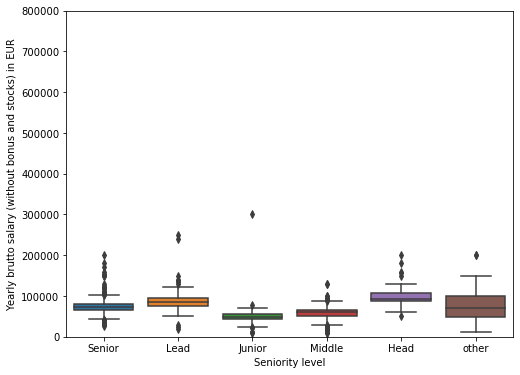

In [33]:
plt.figure(figsize=(8, 6))
fig = sns.boxplot(x=df['Seniority level'], y='Yearly brutto salary (without bonus and stocks) in EUR', 
                  data=pd.concat([df['Yearly brutto salary (without bonus and stocks) in EUR'], df['Seniority level']], axis=1))
fig.axis(ymin=0, ymax=800000)
plt.show()

It is seen that there exists dependence between seniority level and the salary - the lower the position in the hierarchy, the lower the salary at average. So we can potentially say that there could be a linear relationship if we present these levels as ordinal values, where junior = 1 and head = 5.

### Predictor: Age

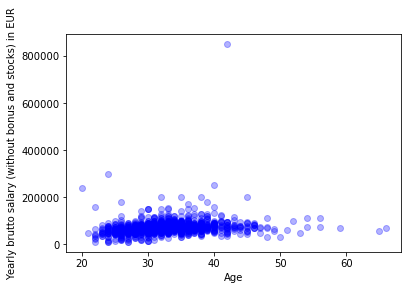

In [34]:
plt.scatter(df_with_dummies['Age'], df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR'], c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('Age')
plt.ylabel('Yearly brutto salary (without bonus and stocks) in EUR')
plt.show()

It is seen that that the older the worker is, generally the greater salary he/she obtains, but at some point the growth of salary stops - it even start to decrease a bit. Seems that there is also logistic relationship - or even a polynomial relationship based on parabola equation

### Predictor: Gender (cat.)

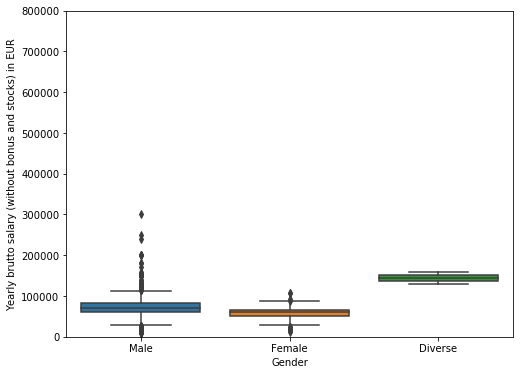

In [35]:
plt.figure(figsize=(8, 6))
fig = sns.boxplot(x=df['Gender'], y='Yearly brutto salary (without bonus and stocks) in EUR', 
                  data=pd.concat([df['Yearly brutto salary (without bonus and stocks) in EUR'], df['Gender']], axis=1))
fig.axis(ymin=0, ymax=800000)
plt.show()

It is seen that, on average, the salary of males is higher than salaries of females, so the relation between this variable and brutto salary is explicit. It may seem strange that 'Diverse' genders obtain far higher salaries but it is only due to the fact that there are only few elements in this 'bucket', so it is not really representative.

### Predictor: Total years of experience

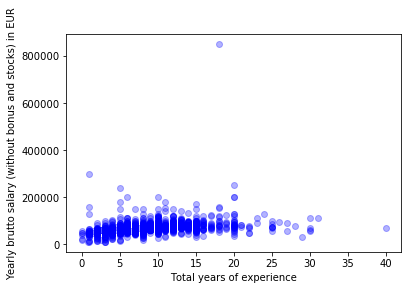

In [36]:
plt.scatter(df_with_dummies['Total years of experience'], df_with_dummies['Yearly brutto salary (without bonus and stocks) in EUR'], c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('Total years of experience')
plt.ylabel('Yearly brutto salary (without bonus and stocks) in EUR')
plt.show()

It is seen that that the more years of experience a worker has, generally the greater salary he/she obtains, but at some point the growth of salary stops - it even start to decrease a bit. Seems that there is also logistic relationship - or even a polynomial relationship based on parabola equation

### Predictor: Have you lost your job due to the coronavirus outbreak? (cat.)

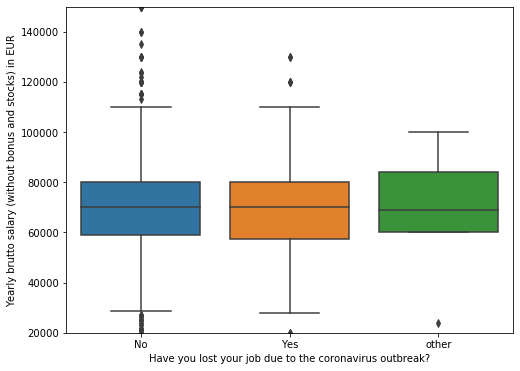

In [37]:
plt.figure(figsize=(8, 6))
fig = sns.boxplot(x=df['Have you lost your job due to the coronavirus outbreak?'], y='Yearly brutto salary (without bonus and stocks) in EUR', 
                  data=pd.concat([df['Yearly brutto salary (without bonus and stocks) in EUR'], df['Have you lost your job due to the coronavirus outbreak?']], axis=1))
fig.axis(ymin=20000, ymax=150000)
plt.show()

It is seen that there is almost no explicit dependence between job loss and brutto salary, however correlation analysis found that if a person has lost a job, he/she generally has a greater salary than a person that has not lost it. Based on the correlation indexes, the correlation is very low

### Predictor: Company size (cat.)

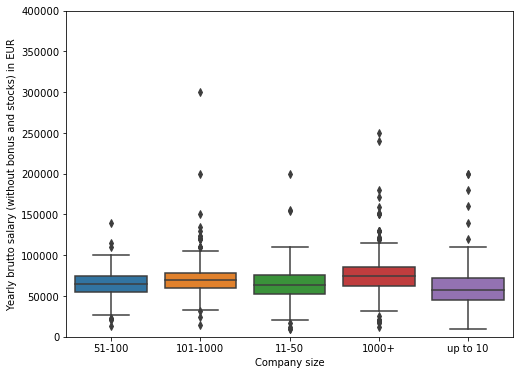

In [38]:
plt.figure(figsize=(8, 6))
fig = sns.boxplot(x=df['Company size'], y='Yearly brutto salary (without bonus and stocks) in EUR', 
                  data=pd.concat([df['Yearly brutto salary (without bonus and stocks) in EUR'], df['Company size']], axis=1))
fig.axis(ymin=0, ymax=400000)
plt.show()

It is seen that the larger the company, the grater is average brutto salary, so there is probably a 'linear' relationship

### Predictor: Main language at work (cat.)

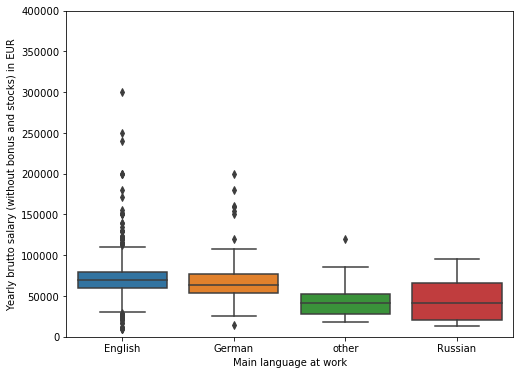

In [39]:
plt.figure(figsize=(8, 6))
fig = sns.boxplot(x=df['Main language at work'], y='Yearly brutto salary (without bonus and stocks) in EUR', 
                  data=pd.concat([df['Yearly brutto salary (without bonus and stocks) in EUR'], df['Main language at work']], axis=1))
fig.axis(ymin=0, ymax=400000)
plt.show()

English-speaking companies tend to have the highest salaries. German-speaking ones have slightly less salaries. The company with any other languages including Russian have significantly lower salaries. By presenting in in a nominal scale, we could say that there is some linear relationship

## Linear Regression

#### Hypothesis:

H0: The linear regression model constructed for a dependent variable 'Yearly brutto salary (without bonus and stocks) in EUR' and the following predictors:
- Annual brutto salary (without bonus and stocks) one year ago.
- Annual bonus+stocks one year ago
- Yearly bonus + stocks in EUR
- Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR
- Years of experience in Germany
- Seniority level (cat.)
- Age
- Gender (cat.)
- Total years of experience
- Have you lost your job due to the coronavirus outbreak? (cat.)
- Company size (cat.)
- Main language at work (cat.)

explains the variation of 'Yearly brutto salary (without bonus and stocks) in EUR'.

H1: The aforementioned model does not explain the variation of 'Yearly brutto salary (without bonus and stocks) in EUR'.

p-value = 0.05.

The hypothesis can be checked based on R^2 of the model as well as based on the results of F-test

In [40]:
import statsmodels.api as sm
df_model = df_with_dummies.dropna(subset=['Age', 'Total years of experience', 'Years of experience in Germany', 'Yearly brutto salary (without bonus and stocks) in EUR', 'Yearly bonus + stocks in EUR', 'Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country', 'Annual bonus+stocks one year ago. Only answer if staying in same country', 'Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR', 'Seniority level_Head','Seniority level_Junior','Seniority level_Lead','Seniority level_Middle','Seniority level_Senior', 'Seniority level_other','Gender_Diverse','Gender_Male','Gender_Female','Have you lost your job due to the coronavirus outbreak?_No','Have you lost your job due to the coronavirus outbreak?_Yes', 'Have you lost your job due to the coronavirus outbreak?_other','Company size_1000+','Company size_101-1000','Company size_11-50','Company size_51-100','Company size_up to 10','Main language at work_English','Main language at work_German','Main language at work_Russian','Main language at work_other'])
df_model.shape

(1250, 44)

In [41]:
x_mult = df_model[['Age', 'Total years of experience', 'Years of experience in Germany', 'Yearly bonus + stocks in EUR', 'Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country', 'Annual bonus+stocks one year ago. Only answer if staying in same country', 'Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR', 'Seniority level_Head','Seniority level_Junior','Seniority level_Lead','Seniority level_Middle','Seniority level_Senior', 'Seniority level_other','Gender_Diverse','Gender_Male','Gender_Female','Have you lost your job due to the coronavirus outbreak?_No','Have you lost your job due to the coronavirus outbreak?_Yes', 'Have you lost your job due to the coronavirus outbreak?_other','Company size_1000+','Company size_101-1000','Company size_11-50','Company size_51-100','Company size_up to 10','Main language at work_English','Main language at work_German','Main language at work_Russian','Main language at work_other']]
y = df_model['Yearly brutto salary (without bonus and stocks) in EUR']
x_mult_constant = sm.add_constant(x_mult)

In [42]:
model = sm.OLS(y, x_mult_constant).fit()

In [43]:
print('R^2 = {:f}'.format(model.rsquared))
print('F-test significance = {:f}'.format(model.f_pvalue))

R^2 = 0.331166
F-test significance = 0.000000


#### Conclusion:

The model is statistically significant and explains 33% of variance of variable 'Yearly brutto salary (without bonus and stocks) in EUR'. H1 is rejected at p-value = 0.05

### Model Characteristics

#### Hypothesis:

H0: The following variables:
- Annual brutto salary (without bonus and stocks) one year ago.
- Annual bonus+stocks one year ago
- Yearly bonus + stocks in EUR
- Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR
- Years of experience in Germany
- Seniority level (cat.)
- Age
- Gender (cat.)
- Total years of experience
- Have you lost your job due to the coronavirus outbreak? (cat.)
- Company size (cat.)
- Main language at work (cat.)

are statistically significant for the linear regression model constructed for a dependent variable 'Yearly brutto salary (without bonus and stocks) in EUR'.

H1: The aforementioned variables are not statistically significant for the linear regression model constructed for a dependent variable 'Yearly brutto salary (without bonus and stocks) in EUR'.

p-value = 0.05

The hypothesis can be checked by estimating p-values of each variable in the constructed model

In [44]:
print(f'Statistically significant model parameters: {model.pvalues[model.pvalues < 0.05].index.values}')

Statistically significant model parameters: ['const' 'Total years of experience' 'Years of experience in Germany'
 'Yearly bonus + stocks in EUR'
 'Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country'
 'Annual bonus+stocks one year ago. Only answer if staying in same country'
 'Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR'
 'Gender_Diverse'
 'Have you lost your job due to the coronavirus outbreak?_Yes']


In [45]:
print(f'Statistically nonsignificant model parameters: {model.pvalues[model.pvalues > 0.05].index.values}')

Statistically nonsignificant model parameters: ['Age' 'Seniority level_Head' 'Seniority level_Junior'
 'Seniority level_Lead' 'Seniority level_Middle' 'Seniority level_Senior'
 'Seniority level_other' 'Gender_Male' 'Gender_Female'
 'Have you lost your job due to the coronavirus outbreak?_No'
 'Have you lost your job due to the coronavirus outbreak?_other'
 'Company size_1000+' 'Company size_101-1000' 'Company size_11-50'
 'Company size_51-100' 'Company size_up to 10'
 'Main language at work_English' 'Main language at work_German'
 'Main language at work_Russian' 'Main language at work_other']


#### Conclusion:

At p-value = 0.05 the following predictors are statistically signficant (so H1 is rejected):

- 'Total years of experience' (had a relationship different from linear with the dependent variable)
- 'Years of experience in Germany' (had a relationship different from linear with the dependent variable)
- 'Yearly bonus + stocks in EUR'\n
- 'Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country'
- 'Annual bonus+stocks one year ago. Only answer if staying in same country'
- 'Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR' (had a relationship different from linear with the dependent variable)

The following predictors are not statistically significant (so H1 is accepted):

- 'Age' (had a relationship different from linear with the dependent variable)
- 'Seniority level'
- 'Gender'
- 'Have you lost your job due to the coronavirus outbreak?'
- 'Company size'
- 'Main language at work'

Interestingly, many variables which had a relationship different from linear with the dependent variable appeared to be statistically signifcant for the model

### Regression equation

In [46]:
l = []
for (param, index) in zip(model.params[1:], model.params.index[1:]):
    l.append('{:.2f}*{}'.format(param, index))
    
print('Y = {:2f} + {}'.format(model.params[0], ' + '.join(l)))

Y = 48090.798371 + -145.16*Age + 601.33*Total years of experience + 604.11*Years of experience in Germany + 0.06*Yearly bonus + stocks in EUR + 0.28*Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country + 0.12*Annual bonus+stocks one year ago. Only answer if staying in same country + 10.38*Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR + 12109.21*Seniority level_Head + -16033.67*Seniority level_Junior + 1393.38*Seniority level_Lead + -13075.77*Seniority level_Middle + -3797.61*Seniority level_Senior + 2246.18*Seniority level_other + 56170.85*Gender_Diverse + -1575.34*Gender_Male + -6446.79*Gender_Female + 2814.36*Have you lost your job due to the coronavirus outbreak?_No + 20838.74*Have you lost your job due to the coronavirus outbreak?_Yes + 4579.53*Have you lost your job due to the coronavirus outbreak?_other + 632.79*Company size_1000+ + 1133.59*Company size_10

### Model description

In [47]:
print(model.summary())

                                              OLS Regression Results                                              
Dep. Variable:     Yearly brutto salary (without bonus and stocks) in EUR   R-squared:                       0.331
Model:                                                                OLS   Adj. R-squared:                  0.316
Method:                                                     Least Squares   F-statistic:                     21.59
Date:                                                    Wed, 13 Apr 2022   Prob (F-statistic):           4.17e-87
Time:                                                            12:17:40   Log-Likelihood:                -14521.
No. Observations:                                                    1250   AIC:                         2.910e+04
Df Residuals:                                                        1221   BIC:                         2.925e+04
Df Model:                                                              28       

- Let's consider the coefficient on the variable Age. The regression coefficient for the variable is negative and equals -145. It can be concluded that an increase in age by one, on average, leads to a decrease of the salary by 145 euro.
- Let's consider the coefficient on the variable Total years of experience. The regression coefficient for the variable is positive and equals 601. It can be concluded that an increase in year of experience by one, on average, leads to an increase of the salary by 601 euro. Similar for Years of experience in Germany, where difference is only in 3 euro per one year of experience.
- Let's consider the coefficient on the variable Yearly bonus + stocks in EUR . The regression coefficient for the variable is positive and equals 0.0647. It can be concluded that an increase in yearly bonuses by one euro, on average, leads to an increase of the salary by 0.0647 euro.
- Let's consider the coefficient on the variable Annual brutto salary (without bonus and stocks) one year ago. The regression coefficient for the variable is positive and equals 0.2773. It can be concluded that an increase in salary for the previous year by one euro, on average, leads to an increase of the current salary by 0.2773 euro.
- Let's consider the coefficient on the variable Annual bonus+stocks one year ago. The regression coefficient for the variable is positive and equals 0.1206. It can be concluded that an increase in annual bonuses in the last year by one euro, on average, leads to an increase of the salary by 0.1206 euro.
- Let's consider the coefficient on the variable Additional monetary support from your employer due to Work From Home. The regression coefficient for the variable is positive and equals 10.3808. It can be concluded that an increase in monetary support by one euro, on average, leads to an increase of the current salary by 10.3808 euro.
- Let's consider the coefficients on the dummy variables for Seniority level. If the level is Head, the regression coef equals 1.211e+04, so being a Head increases the salary at average by 12110 euro. If the level is Junior, the regression coef equals -1.603e+04, so being a Junior decreases the salary at average by 16030 euro. If the level is Lead, the coef equals 1393, so that being a Lead increases the salary at average by 1393. If the level is Middle, the coef equals -1.308e+04, so being a Moddle decreases the salary at average by 13080 euro. If the level is Senior, the coef equals -3797, so being a Senior decreases the salary at average by 3797.
- Let's consider the coefficients on the dummy variables for Gender. If the gender is male, the regression coef equals -1575, so being a male at average decreses the salary by 1575 euro. If the gender is female, the coef equals -6446, so being a female at average decreses the salary by 6446 euro.
- Let's consider the coefficients on the dummy variables for 'Have you lost your job due to the coronavirus outbreak?'. If no, the regression coef is 2814, meaning that having lost a job due to Covid increases the current salary by 2814. If yes, the regression coef is 20840, meaning that not having lost a job due to pandemic increases the current salary by 20840.
- Let's consider the coefficients on the dummy variables for Company size. If size is 1000+, then regression coef is 632, so working in the company of size > 1000 increses salary by 632 at average. If size is (101-1000), the regression coef is 1133, meaning that working in this company increases the salary by 1133 at average. If size is (11-50), the coef is -5088, so working in these companies decreses the salary by 5088 at average. If size is (51-100), the coef is -6315, so working in these companies decreses the salary by 6315 at average. Lastly, if size is up to 10, the coef is -8900, so working in this type of companies decreses the salary by 8900 at average.
- Let's consider the coefficients on the dummy variables for Main language. If the language is English, the regression coef is 4988, so using English as a main language increases the salary by 4988 at average. If the language is German, the coef is 519, so working using German increses the salary by 519 at average. If the language is Russian, the regression coefficient is -18450, so using Russian as the main language at work decreases the salary by 18450 at average

### Model with standardized coefficients (beta coefficients)

In [48]:
from scipy.stats.mstats import zscore
print(sm.OLS(zscore(y), zscore(x_mult)).fit().summary())

                                                   OLS Regression Results                                                  
Dep. Variable:     Yearly brutto salary (without bonus and stocks) in EUR   R-squared (uncentered):                   0.331
Model:                                                                OLS   Adj. R-squared (uncentered):              0.316
Method:                                                     Least Squares   F-statistic:                              21.61
Date:                                                    Wed, 13 Apr 2022   Prob (F-statistic):                    3.45e-87
Time:                                                            12:17:41   Log-Likelihood:                         -1522.3
No. Observations:                                                    1250   AIC:                                      3101.
Df Residuals:                                                        1222   BIC:                                      3244.
Df Model

It is seen that predictors with the greatest influence are the following:

- Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country
- Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR
- Seniority level
- Have you lost your job due to the coronavirus outbreak?

Looking at standard errors, it is possible to say that the following predictors are less precise than others:

- Seniority level
- Gender
- Company size
- Main language

## Model Diagnostics

#### Residuals

To evaluate how he model fits the sample data, the residuals can be calculated. Small residuals show that fits the sample data well

##### Hypothesis:

H1: The distribution of residuals is different from the normal distribution

H0: The distribution of residuals is not different from the normal distribution

p-value = 0.05

In [49]:
p = stats.kstest(model.resid, 'norm', args=(model.resid.mean(), model.resid.std())).pvalue
print('P-value: {:.3f}'.format(p))

P-value: 0.000


C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

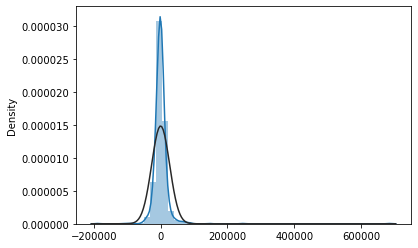

In [50]:
sns.distplot(model.resid, fit=stats.norm) 

##### Conclusion:

H1 is accepted at p-value = 0.05: the distribution of residuals is different from the normal distribution.

Indeed, there are some outliers, which is seen on the plot. The model does not really well fit the sample data

#### Multicollinearity

Multicollinearity can be checked to find any strong correlations between predictors

In [51]:
vifs = np.array([vif(model.model.exog, i) for i in range(model.model.exog.shape[1])])

vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model.params.index[1:]
vif_df.sort_values(by=['VIF'])

,VIF,Features
6,1.046939,Have you received additional monetary support ...
4,1.191040,Annual brutto salary (without bonus and stocks...
13,1.280978,Gender_Diverse
3,1.476782,Yearly bonus + stocks in EUR
5,1.500874,Annual bonus+stocks one year ago. Only answer ...
2,1.639295,Years of experience in Germany
18,1.758464,Have you lost your job due to the coronavirus ...
0,2.323790,Age
1,2.571368,Total years of experience
26,2.716823,Main language at work_Russian


##### Conclusion:

It is seen that there exists a problem with multicollinearity which appeared due to particular dummy variables which were constructed on the basis of categorical variables. All the categorical variables which appeared to be not statistically significant obtained very high index of variance-inflation factor. Since they are not statistically significant and provide multicollinearity, they can potentially be removed in future analysis.
In contrast to these categorical variables, all the float-typed variables show very low variance-inflation factor (<2.6).

### Heteroscedasticity

To check the well-fitness of the model, the heteroscedasticity can be evaluated. If the model is well-fitted, there should be no pattern to the residuals plotted against the fitted values.

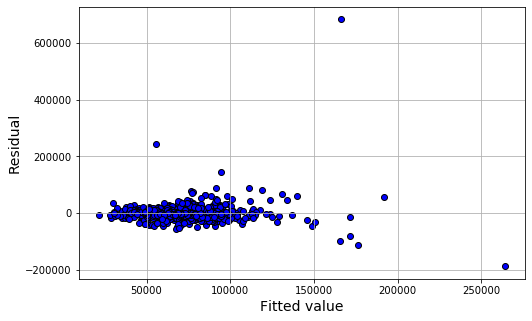

In [52]:
plt.figure(figsize=(8,5))
plt.scatter(x=model.fittedvalues, y=model.resid, color='blue', edgecolor='k')
plt.grid(True)
plt.xlabel('Fitted value', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.show()

##### Conclusion:

Generally, the model can be characterized to be both homoscedastic (for the first 100 000 fitted values) then heteroscedastic (for all the fitted values). Since we evaluate all the model and variance of the residuals is non-constant throughout the whole model (especially in comparison of the left and the right sides of the plot), we have to say that there still exists a problem of heteroscedasticity.

According to Durbin-Watson, there indeed exists a slight heteroscedasticity in the model (value equals 2.004, while only values in range [1,2] represent homoscedasticity).

### Outliers and influential cases

Influential cases can be detected using DFFITS techniqe. Outliers can be detected by checking the standardized residuals of cases in the sample

In [53]:
influence = model.get_influence()
inf_sum = influence.summary_frame()
inf_sum

,dfb_const,dfb_Age,dfb_Total years of experience,dfb_Years of experience in Germany,dfb_Yearly bonus + stocks in EUR,dfb_Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country,dfb_Annual bonus+stocks one year ago. Only answer if staying in same country,"dfb_Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR",dfb_Seniority level_Head,dfb_Seniority level_Junior,...,dfb_Main language at work_English,dfb_Main language at work_German,dfb_Main language at work_Russian,dfb_Main language at work_other,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
Timestamp,,,,,,,,,,,,,,,,,,,,,
01/01/2021 10:51:57,0.000094,-0.000207,0.000062,0.000029,-0.000100,-0.000049,-0.000032,-0.000105,0.000011,-0.000002,...,0.000032,0.000022,0.000016,0.000021,2.412642e-08,0.008769,0.009017,0.000836,0.008765,0.000836
01/01/2021 13:40:08,0.000054,-0.000009,0.003425,-0.006363,-0.001283,-0.002254,0.003210,-0.002602,-0.000079,-0.000174,...,0.000650,0.000764,0.000303,0.000152,6.475361e-06,0.124296,0.012009,0.013703,0.124246,0.013698
01/12/2020 00:06:49,-0.001596,0.003356,-0.017720,-0.003859,0.001116,0.011659,-0.009207,-0.002767,0.000090,-0.007992,...,-0.001707,0.007347,-0.001132,-0.001770,1.779784e-04,0.593882,0.014423,0.071843,0.593724,0.071824
01/12/2020 00:16:18,0.000742,-0.001804,0.001849,0.004950,0.000649,-0.000325,0.001070,0.001633,-0.000315,0.000203,...,0.000074,0.000088,0.000518,0.000371,7.615223e-06,-0.223224,0.004412,-0.014861,-0.223138,-0.014855
01/12/2020 00:20:42,0.000976,-0.001818,0.001348,0.002635,-0.001521,0.000606,-0.005029,0.000949,0.000316,0.000487,...,-0.000315,-0.000208,0.000326,0.000414,7.096231e-06,-0.123944,0.013219,-0.014345,-0.123894,-0.014340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30/11/2020 23:38:05,-0.000596,-0.002125,0.006777,-0.005507,-0.000959,0.004850,-0.004826,0.004246,-0.000966,0.000096,...,0.000225,-0.000068,-0.000411,-0.000884,1.933944e-05,0.286574,0.006783,0.023682,0.286466,0.023673
30/12/2020 02:23:59,-0.000772,-0.002918,0.012547,-0.001318,0.001873,0.006049,0.001373,0.002383,-0.002119,0.002109,...,-0.001284,-0.000481,-0.000391,-0.000508,5.096164e-05,-0.290876,0.017167,-0.038443,-0.290767,-0.038429
30/12/2020 13:18:32,0.000675,-0.001894,0.000239,-0.002654,0.000387,-0.000613,-0.001672,-0.000417,0.000161,-0.000693,...,-0.000350,-0.000348,-0.000670,-0.001181,9.279298e-06,0.170760,0.009144,0.016404,0.170692,0.016398


#### Potential influential cases

Such cases can be found using difference in fit(s) diagnostic (DFFITS). DFFITS value shows how influential a particual case on the whole model

In [54]:
inf_sum['dffits'][(inf_sum['dffits']>1) | (inf_sum['dffits']<-1)].sort_values()

Timestamp
25/11/2020 18:02:06   -16.033103
25/11/2020 12:27:53    -7.295709
24/11/2020 18:48:30    -3.151249
24/11/2020 11:44:51    -1.949794
05/01/2021 23:03:40     1.003584
26/11/2020 22:41:33     1.014934
25/11/2020 10:58:13     1.045905
24/11/2020 21:36:24     1.064646
25/11/2020 13:26:21     1.256131
26/11/2020 17:08:47    12.653175
Name: dffits, dtype: float64

#### Potential outliers

Based on standardized residuals, it is possible to identify outliers (whose value has to be less than -3 or greater than 3)

In [55]:
inf_sum['standard_resid'][(inf_sum['standard_resid']>3) | (inf_sum['standard_resid']<-3)].sort_values()

Timestamp
25/11/2020 18:02:06   -11.474548
25/11/2020 12:27:53    -5.166308
24/11/2020 18:48:30    -4.863149
24/11/2020 11:44:51    -3.970217
05/01/2021 23:03:40     3.131085
27/11/2020 13:02:41     3.338408
24/11/2020 21:36:24     3.427918
26/11/2020 22:41:33     5.454953
25/11/2020 13:26:21     9.073754
26/11/2020 17:08:47    26.395824
Name: standard_resid, dtype: float64

#### Conclusions:

The quantity of influetial cases and outliers is sufficiently low: both influential cases and outliers have only 10 rows. Interestingly, they differ only in one record, while all the others are the same. The existence of these outliers can cause the model to be biased. Since both these sets significantly intersect with each other, it is possible to say that, indeed, these outliers had influenced them model and the regression coefficients.

It could be potentially a good strategy for the future analysis to remove these outliers and check the result model, which can now become less biased

### Final Conclusions

The constructed linear model appeared to be statistically significant but explains only 33% variance of the worker's salary. Since this indicator is quite low, the model still has to be readjusted and refined. For instance, the statistically insignificant variables can be removed from the model, which will also help to avoid the problem of multicollinearity. Another way is to remove all the outliers from the sample. As it is presented above, these outliers highly influence the model since most of them are represented in the set of the most influential cases. With the outliers removed, the problem of heteroscedasticity can also potentially disappear.

From my persepective, it is also better to try removing all variables which do not have a linear relationship with the dependent variable since they still cannot be well-fitted in the linear regression model. Potentially, the logistic regression can be constructed for these variables as the relationship between each of these variables and dependent one is more close to logistic.